In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import yfinance as yf

In [82]:
%load_ext tensorboard

In [4]:
df = yf.download("BABA", start="2010-01-01", end="2023-10-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
df["time_idx"] = df.index.factorize()[0]
df["group"] = "BABA"  # If forecasting only one stock, use a constant group ID

In [7]:
df

Price,Close,High,Low,Open,Volume,time_idx,group
Ticker,BABA,BABA,BABA,BABA,BABA,,
Date,,,,,,,
2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400,0,BABA
2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800,1,BABA
2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800,2,BABA
2014-09-24,87.467674,87.467674,84.232424,85.439608,32088000,3,BABA
2014-09-25,85.874184,88.365812,85.468572,87.969852,28598000,4,BABA
...,...,...,...,...,...,...,...
2023-09-25,84.232422,84.280705,82.832085,82.938318,9897200,2268,BABA
2023-09-26,82.967293,84.087555,82.764480,83.498449,9666600,2269,BABA


In [ ]:
df = df.reset_index()  # This will move 'Ticker' and 'Date' into columns
df.columns = df.columns.droplevel(1)

In [34]:
df

Price,index,Date,Close,High,Low,Open,Volume,time_idx,group
0,0,2014-09-19,90.673950,96.284936,86.868906,89.524709,271879400,0,BABA
1,1,2014-09-22,86.810966,89.766149,86.434326,89.524712,66657800,1,BABA
2,2,2014-09-23,84.184128,87.380754,83.652972,85.893503,39009800,2,BABA
3,3,2014-09-24,87.467674,87.467674,84.232424,85.439608,32088000,3,BABA
4,4,2014-09-25,85.874184,88.365812,85.468572,87.969852,28598000,4,BABA
...,...,...,...,...,...,...,...,...,...
2268,2268,2023-09-25,84.232422,84.280705,82.832085,82.938318,9897200,2268,BABA
2269,2269,2023-09-26,82.967293,84.087555,82.764480,83.498449,9666600,2269,BABA
2270,2270,2023-09-27,83.237709,83.585378,82.378195,83.421196,7233900,2270,BABA
2271,2271,2023-09-28,82.609970,82.947980,81.417272,81.982233,10093600,2271,BABA


In [37]:
df = df[["time_idx", "group", "Close", "Open", "High", "Low", "Volume"]]

In [47]:
df["is_future"] = 0

In [65]:
max_encoder_length = 100  # number of past days to use
max_prediction_length = 30  # number of future days to predict

training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="Close",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx", "is_future"],  # e.g., time_idx, known future dates
    time_varying_unknown_reals=["Close"],   # target and possibly others
    static_categoricals=["group"],
)

In [66]:
from pytorch_forecasting import NaNLabelEncoder
from torch.utils.data import DataLoader

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)

In [83]:
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_forecasting.metrics import RMSE
import lightning.pytorch as pl
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="tft")

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=RMSE(),  # or QuantileLoss() for probabilistic
    log_interval=10,
)

trainer = pl.Trainer(logger=logger, max_epochs=60, gradient_clip_val=0.1)
trainer.fit(tft, train_dataloaders=train_dataloader)

c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined 

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:488: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
`Trainer.fit` stopped: `max_epochs=60` reached.


In [84]:
%tensorboard --logdir=lightning_logs

In [ ]:
# # Create a prediction dataset (e.g., last 60 days for forecasting next 5)
# encoder_data = df[df["time_idx"] > df["time_idx"].max() - max_encoder_length]
# decoder_data = pd.DataFrame({
#     "time_idx": range(df["time_idx"].max() + 1, df["time_idx"].max() + max_prediction_length + 1),
#     "group": "BABA",
# })
# prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [85]:
future_time_idx = range(df["time_idx"].max() + 1, df["time_idx"].max() + 31)

decoder_data = pd.DataFrame({
    "time_idx": future_time_idx,
    "group": "BABA",
    "Close": [0.0] * 30,   # dummy values instead of NaN
    "is_future": [1] * 30, # new column to indicate decoder steps
})

encoder_data = df[df.time_idx > df.time_idx.max() - 100].copy()
encoder_data["is_future"] = 0

prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)


In [75]:
future_time_idx

range(2273, 2303)

In [76]:
prediction_data

,time_idx,group,Close,Open,High,Low,Volume,is_future
0,2173,BABA,79.403687,77.786058,79.828617,77.404591,13457400.0,0
1,2174,BABA,80.108681,79.326428,81.605591,78.969099,16868100.0,0
2,2175,BABA,84.879471,82.503735,85.449265,81.914629,28104200.0,0
3,2176,BABA,82.416809,83.739885,83.739885,81.856682,19031400.0,0
4,2177,BABA,85.314049,84.145496,85.371999,82.892926,23691200.0,0
...,...,...,...,...,...,...,...,...
125,2298,BABA,0.000000,NaN,NaN,NaN,NaN,1
126,2299,BABA,0.000000,NaN,NaN,NaN,NaN,1
127,2300,BABA,0.000000,NaN,NaN,NaN,NaN,1
128,2301,BABA,0.000000,NaN,NaN,NaN,NaN,1


In [86]:
prediction_dataset = TimeSeriesDataSet.from_dataset(training, prediction_data, predict=True)
prediction_dataloader = prediction_dataset.to_dataloader(train=False, batch_size=1)

# Predict
pred = tft.predict(prediction_dataloader, mode="raw", return_x=True)

c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\pytorch_forecasting\data\timeseries\_timeseries.py:1709: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Pam\miniconda3\envs\ml\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


In [87]:
predicted_close = pred.output.prediction.squeeze().detach().cpu().numpy()
predicted_close

array([83.77812 , 85.45865 , 85.35409 , 85.27749 , 85.25384 , 85.25022 ,
       85.25036 , 85.25153 , 85.252914, 85.25432 , 85.256485, 85.26108 ,
       85.26559 , 85.2673  , 85.268486, 85.26941 , 85.270485, 85.27169 ,
       85.27263 , 85.27373 , 85.27469 , 85.275894, 85.27708 , 85.27817 ,
       85.27956 , 85.28093 , 85.2824  , 85.28399 , 85.285645, 85.28748 ],
      dtype=float32)

In [88]:
df["time_idx"]

0          0
1          1
2          2
3          3
4          4
        ... 
2268    2268
2269    2269
2270    2270
2271    2271
2272    2272
Name: time_idx, Length: 2273, dtype: int64

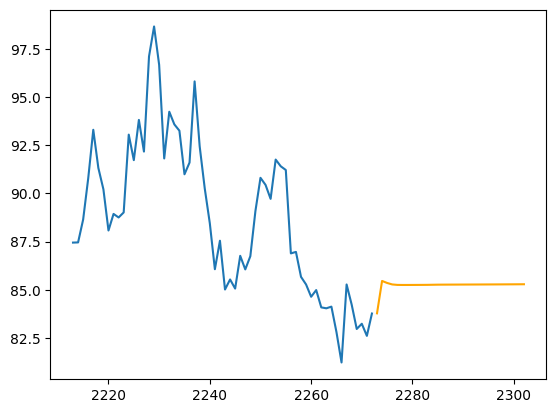

In [89]:
plt.plot(df["time_idx"][-60:], df["Close"][-60:], label="Historical Close")
plt.plot(future_time_idx, predicted_close, label="Predicted Close", color='orange')